# Fixing initialization problems

In rare cases, the `map_fit` and/or `bayes_fit` methods may not arrive at an appropriate fit of the data. This is most often due to poor initialization of the model parameters. This tutorial demonstrates two ways to address the issue: (1) initializing the parameters from a ridge solution and (2) changing the random seed.

In [2]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
%matplotlib notebook
import glob

from bayes_drt.inversion import Inverter
from bayes_drt import eis_utils as gt

%load_ext autoreload
%autoreload 2

In [6]:
# set plotting parameters
tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [24]:
# Convenience functions for visualization
def plot_drt_result(inv,Zdf,plot_ci=False,tau_plot=np.logspace(-7,3,200)):
    fig, axes = plt.subplots(2,2,figsize=(7.5,6))
    freq = Zdf['Freq'].values
    unit_scale = gt.get_unit_scale(Zdf)
    scale_factor = gt.get_scale_factor(Zdf)
    
    # plot noisy data
    gt.plot_full_eis(Zdf,axes=axes.ravel()[:3],alpha=0.4,label='Data',bode_cols=['Zreal','Zimag'],s=20)
    # get fitted impedance from DRT instance
    Z_pred = inv.predict_Z(freq)
    df_pred = gt.construct_eis_df(freq,Z_pred)
    # plot impedance fit
    gt.plot_full_eis(df_pred,axes=axes.ravel()[:3],alpha=0.8,label='Fit',bode_cols=['Zreal','Zimag'],
                     c='k',plot_func='plot')

    # get the recovered DRT    
    g_pred = inv.predict_distribution('DRT',tau_plot)
    # scale to Mohms
    g_pred /= scale_factor
    # plot the recovered DRT
    if plot_ci:
        # plot mean and 95% credibility interval (CI) if MCMC sampling used
        g_lo = inv.predict_distribution('DRT',tau_plot,percentile=2.5)/scale_factor
        g_hi = inv.predict_distribution('DRT',tau_plot,percentile=97.5)/scale_factor
        axes[1,1].plot(tau_plot,g_pred,c='k',label='Posterior mean',alpha=0.8)
        axes[1,1].fill_between(tau_plot,g_lo,g_hi,color='k',label='95% CI',alpha=0.15)
    else:
        # otherwise plot point estimate only
        axes[1,1].plot(tau_plot,g_pred,c='k',label='Recovered',alpha=0.8)
        
    # mark measurement boundaries in DRT plot
    axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].min()),ls=':',c='gray',label='Data limit')
    axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].max()),ls=':',c='gray')
    
    axes[1,1].set_xscale('log')
    axes[1,1].set_xlabel(r'$\tau$ / s')
    axes[1,1].set_ylabel('$\gamma \ / \ \mathrm{M}\Omega$')

    for ax in axes.ravel():
        ax.legend()
        
    for ax in [axes[0,0],axes[1,0],axes[1,1]]:
        ax.axhline(0,c='k',lw=0.5)

    fig.tight_layout()

# 1. Load data

For this tutorial, we use an experimental spectrum obtained from a protonic ceramic thin film.

In [4]:
# load experimental data
file = '../data/experimental/PDAC_COM3_02210_Contact111_2072C_350C.txt'
Zdf = gt.read_eis_zdata(file)
# make complex impedance array
Z = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
# get frequency vector for convenience
freq = Zdf['Freq'].values

Reading timestamp failed for file ../data/experimental/PDAC_COM3_02210_Contact111_2072C_350C.txt


<IPython.core.display.Javascript object>


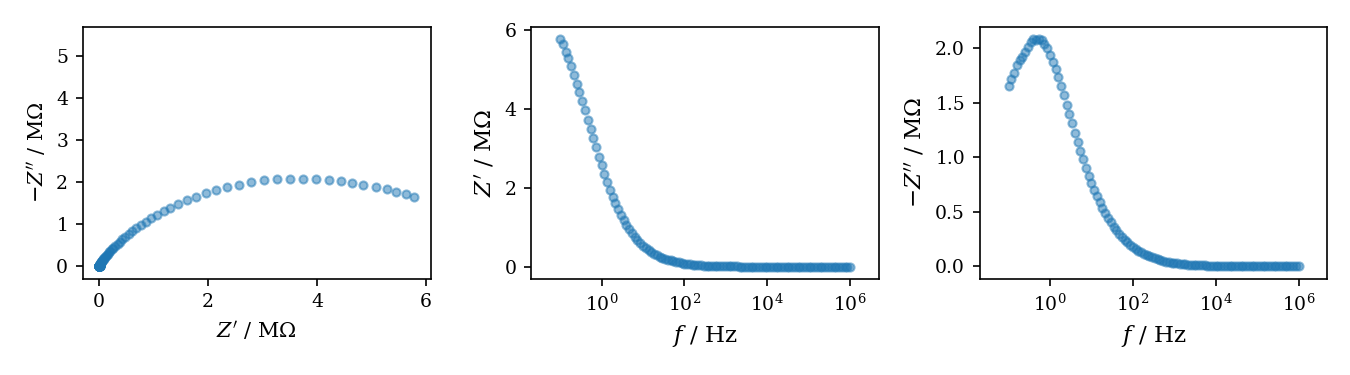

In [7]:
# plot the impedance data
axes = gt.plot_full_eis(Zdf,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5)

# 2. Run `map_fit` with random initialization

By default, the model parameters are initialized randomly. In most cases, this works well; the optimizer/sampler is able to shift the parameters to an appropriate optimum from this random starting point. However, in rare cases, the optimizer/sampler may not reach an appropriate solution, as illustrated below. For this example, we illustrate the issue and solution with the `map_fit` method, but the same principles apply to the `bayes_fit` method (although the HMC sampler employed by `bayes_fit` is generally less sensitive to the initial parameter values).

In [9]:
# Create an Inverter instance with expanded basis_freq,
# making sure to use 10 ppd spacing for basis frequencies
inv = Inverter(basis_freq=np.logspace(7,-3,101))

start = time.time()
inv.map_fit(freq,Z)
elapsed = time.time() - start
print('MAP fit time: {:.2f} s'.format(elapsed))

MAP fit time: 44.72 s


<IPython.core.display.Javascript object>


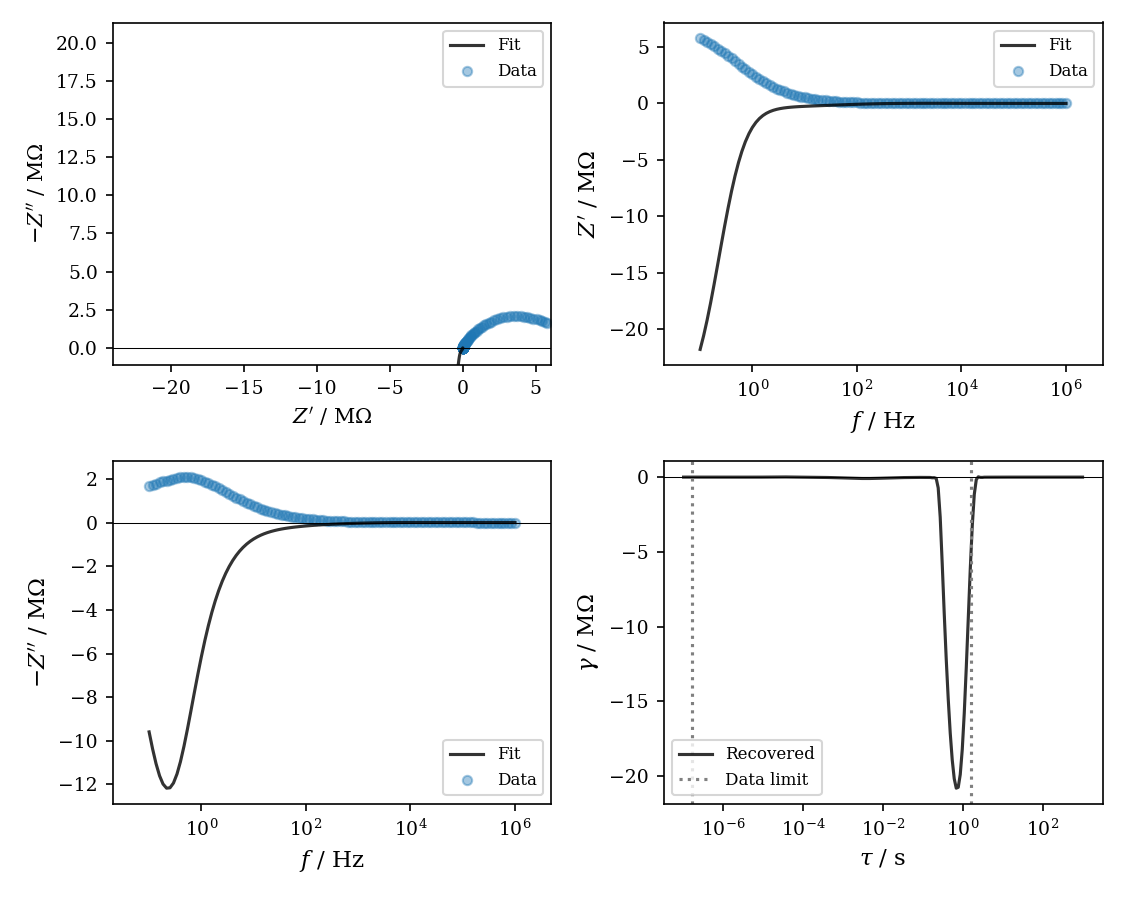

In [17]:
# plot DRT and fit
plot_drt_result(inv,Zdf)

 The fit is clearly not aligned with the data. In addition, if you check the terminal output from the `map_fit` call, you will see a message from `stan`: "Optimization terminated normally: Maximum number of iterations hit, may not be at an optima". This indicates that the optimizer reached the maxiumum number of allowed iterations (set to 50,000 by default) without converging.
 
# 3. Initialize from ridge
 
The solution obtained above is clearly not satisfactory. The issue lies in the random initialization of model parameters: this particular set of starting parameters sets the optimizer off in the wrong direction such that it fails to converge to an appropriate solution within the allowed iterations. We can use the `init_from_ridge` argument to run a hyperparametric ridge fit first, and then use the results of the ridge fit to provide initial parameter estimates to the hierarchical Bayesian model. The ridge fit runs extremely quickly (<1 s), so the computational cost is very low.

In [18]:
start = time.time()
# initialize from ridge solution
inv.map_fit(freq,Z,init_from_ridge=True)
elapsed = time.time() - start
print('MAP fit time with ridge initialization: {:.2f} s'.format(elapsed))

c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\inversion.py:671: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


MAP fit time with ridge initialization: 18.58 s


<IPython.core.display.Javascript object>


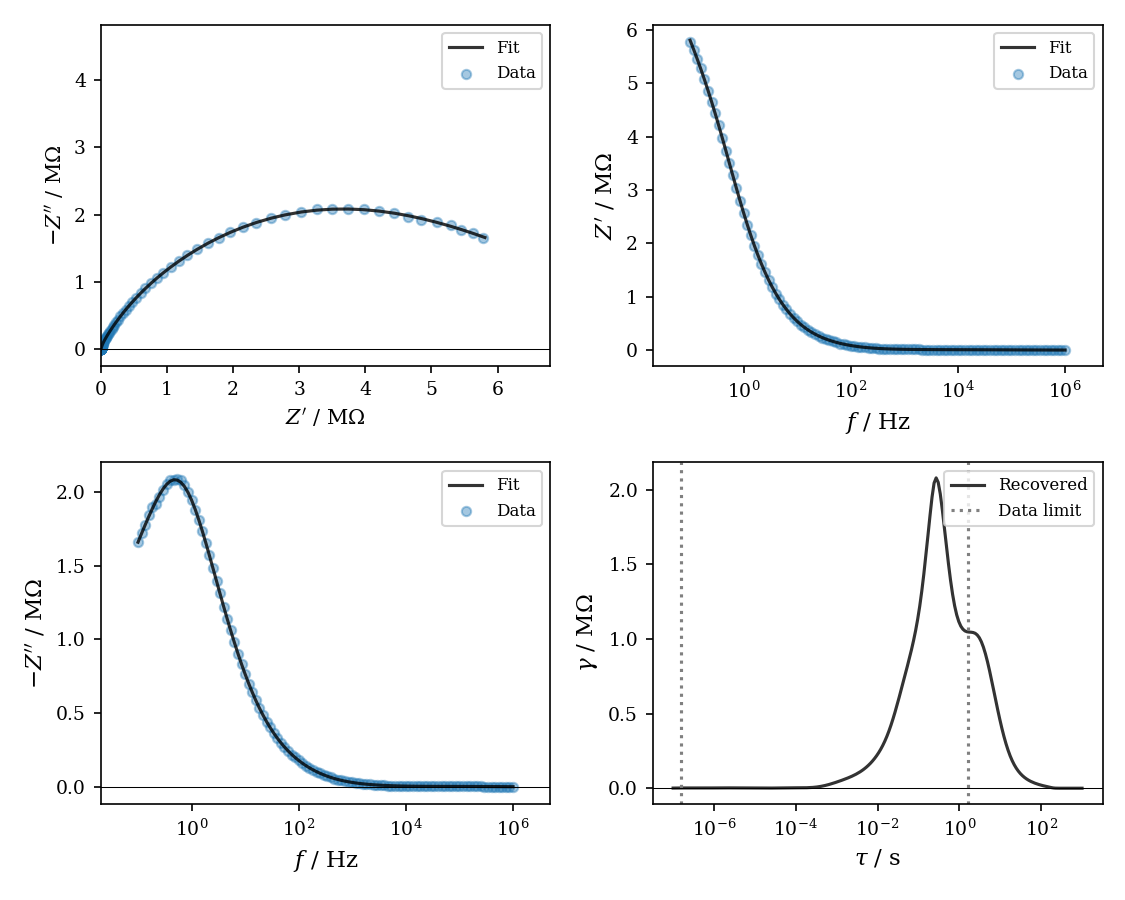

In [19]:
# plot DRT and fit
plot_drt_result(inv,Zdf)

The result with ridge initialization is clearly a much better fit of the data. The ridge initialization can prove useful in a number of situations, but in general is not necessary. In most cases, `map_fit` will yield nearly identical solutions whether `init_from_ridge` is set to `True` or `False`. In some cases, using `init_from_ridge=True` may improve the results, as shown above, but in other cases it may result in slightly worse fits. My general recommendation is to leave `init_from_ridge` set to `False` (the default) and use it only when there appears to be an issue with the standard `map_fit` results.

# 4. Change the random seed
 
Since the issue arises because of the random parameter initialization, we can also try changing the random seed used for initialization. By default, the random seed is set to 1234, but it may be changed by passing an argument to the `random_seed` parameter. This method is less reliable than using `init_from_ridge=True`, but it may be handy for diagnosing issues or in cases when `init_from_ridge` cannot be used (such as multi-distribution fits).

In [22]:
start = time.time()
# change the random seed to 123
inv.map_fit(freq,Z,random_seed=123)
elapsed = time.time() - start
print('MAP fit time: {:.2f} s'.format(elapsed))

MAP fit time: 16.29 s


<IPython.core.display.Javascript object>


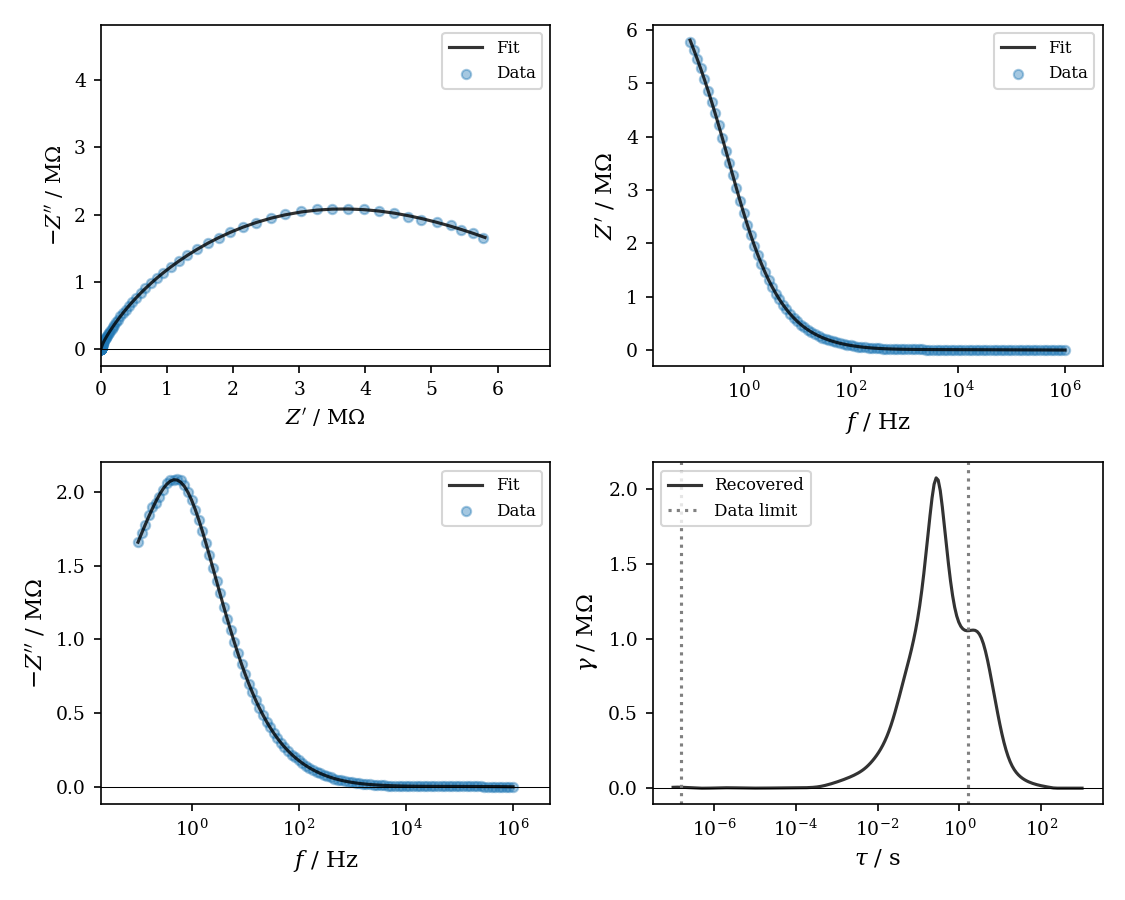

In [23]:
# plot DRT and fit
plot_drt_result(inv,Zdf)

Changing the random seed also results in a good fit that looks very similar to the fit initalized from the ridge solution.